This notebook rolls together much of what happens in .../daq.../teledyne/adq.../spurAnlysis.ipynb
It should be though of as 

In [8]:
import sys 
import numpy as np
import settings as s
import matplotlib.pyplot as plt 
import importlib
importlib.reload(s)
from cupyx.profiler import benchmark
import h5py
import os
import re
import time
import datetime
from datetime import datetime

sys.path.insert(0, '../../../drlib')
import drlib as dr
%matplotlib widget

def mad_np(arr):
    median = np.median(arr)
    return np.median(np.abs(arr-median))

def freq2Idx(freq, freqsAll):
    return int(freq/freqsAll[-1] * len(freqsAll))

def idx2Freq(idx, freqs):
    return  ((freqs[-1] - freqs[0])/len(freqs) * idx) + freqs[0]

dataDir         = '/drBiggerBoy/moreTesting_3_23_23/'

totalAcqs       = int(open(s.SAVE_DIRECTORY + 'database.txt', 'r'
                    ).readlines()[-1].split(',')[0].strip()) + 1 

print(totalAcqs)
    

594


diff mean:              65.53445392074198
diff median:            65.533829
diff STD:               0.004388645789291895
diff percent error:     0.006696700020724315
expected single time:   6.553599999999999
total time:             38861.931175
expected total time:    65536.0


Text(0, 0.5, 'Time Delta (Seconds)')

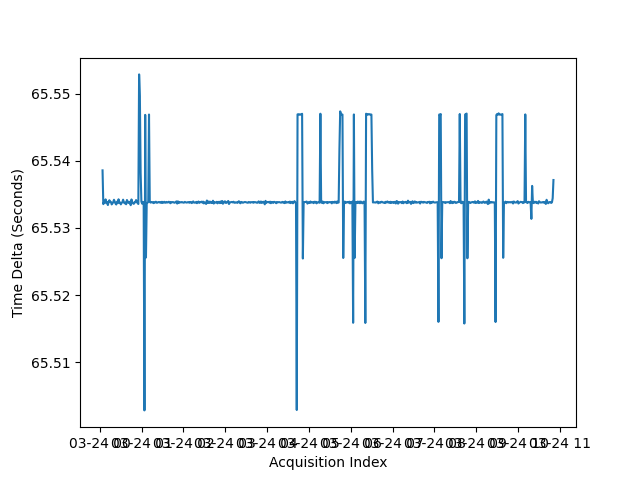

In [7]:
#time delta analysis
datetimes_str = np.loadtxt(f'{dataDir}database.txt',
                        skiprows=1,
                        usecols=1,
                        delimiter=',',
                        dtype=str)
datetimes =[]
for date in datetimes_str:
    data = date[10]
    datetimes.append(datetime.strptime(date, ' %Y-%m-%d %H:%M:%S.%f'))


diff = []
for i in range(len(datetimes)-1):
    diff.append((datetimes[i+1] - datetimes[i]).total_seconds())

print(f"diff mean:              {np.mean(diff)}")
print(f"diff median:            {np.median(diff)}")
print(f"diff STD:               {np.std(diff)}")
print(f"diff percent error:     {np.std(diff)/np.mean(diff) * 100}")
print(f"expected single time:   {2**24/s.SAMPLE_RATE * 250}")
print(f"total time:             {(datetimes[-1] - datetimes[0]).total_seconds()}")
print(f"expected total time:    {2**24/s.SAMPLE_RATE * s.NOF_BUFFERS_TO_RECEIVE * s.NOF_ACQUISITIONS_TO_TAKE}")

plt.close('all')
plt.figure()
plt.plot(datetimes[1:], diff)
plt.xlabel('Acquisition Index')
plt.ylabel('Time Delta (Seconds)')

In [36]:
#pack pre proc dataset

try:
    f.close()
    print("closed")
except:
    print("didn't close")
    pass

rawDataDir      = dataDir + 'data/'
fileList        = os.listdir(rawDataDir)
fileList.sort(key=lambda f: int(re.sub('\D', '', f)))
newDataDir      = dataDir
fileName        = 'packedh5.hdf5'
if 1: #will overwrite!!!

    f               = h5py.File(newDataDir + fileName, 'w')

    #init empty dataset
    print(f'initilizing dataset 8388609x{totalAcqs}')
    spec_W    = f.create_dataset('spec_W_chB', (8388609, totalAcqs), chunks = (2**16,2**0), dtype = 'f')
    print(spec_W)

    ##############################################################
    #Main loop
    ##############################################################
    numFiles        = 0
    numMeasData     = 0
    numRigolSpec    = 0

    compType = False
    chunks = None #must add chunks arg to create dataset calls

    for fileidx, file in enumerate(fileList):
        if fileidx % 10 == 0:
            print(file)
        dataset         = h5py.File(rawDataDir +  file, 'r')
        numFiles        += 1
        measDataKeys    = list(dataset.keys())
        measDataKeys.sort(key=lambda f: int(re.sub('\D', '', f)))
        #measDataKeys = [int(key) for key in measDataKeys]

        for measData in measDataKeys:
            measDataInt = int(measData)
            '''Dumb check. Is the date in raw h5 measData the same as what
            the database thinks it is? Since we previously check that dates
            are consectutive this also checks that dates 
            in raw h5 are consecutive'''
            '''datasetDf   = pd.read_hdf(rawDataDir + file, key = measData)#raw H5 
            dateTimeStr = datasetDf.columns[0][0]#datetime extracted from raw H5
            dateTime    = datetime.strptime(dateTimeStr, '%Y-%m-%d %H:%M:%S.%f')'''

            '''Check database at a measData has the same datetime as we are about
            to load into new h5'''
            '''if not (dateTime==database[database['measData'] == measDataInt].index):
                print('Dates got jumbled at measData', measDataInt)'''

            spec_W_np        = np.float32(dataset[measData]['chBSpec_W'])
            #print(measData)
            #termSpec    = np.float32(dr.fft2Watts(datasetDf.iloc[:,0][:]))
            #diffSpec    = np.float32((antSpec-termSpec))

            spec_W[:, measDataInt]    = spec_W_np

f.close()

closed
initilizing dataset 8388609x594
<HDF5 dataset "spec_W_chB": shape (8388609, 594), type "<f4">
0.hdf5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
1.hdf5
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
2.hdf5
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
3.hdf5
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
4.hdf5
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
5.hdf5
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
6.hdf5
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
7.hdf5
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
8.hdf5
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
9.hdf5
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
10.hdf5
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
11.hdf5
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
12.hdf5
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
13.hdf5
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
14.hdf5
224

In [57]:
#Average and save spectra

#location of packed h5
fileName        = 'packedh5.hdf5'


f               = h5py.File(dataDir + fileName, 'r')

def avgSpecFromPacked(avgIdxs):
    sum = np.zeros(2**23+1)
    for i in avgIdxs:
        sum += f['spec_W_chB'][:,i]
    avgSpec = sum/(len(avgIdxs))
    return avgSpec

antIdxs     = range(0, totalAcqs-1, 2)[0:-1]
termIdxs    = range(1, totalAcqs-1, 2)


avgAntSpec  = avgSpecFromPacked(antIdxs)
avgtermSpec  = avgSpecFromPacked(termIdxs)

np.save('/drBiggerBoy/moreTesting_3_23_23/avgAntSpec_W_296Avgs_3_23_23', avgAntSpec)
np.save('/drBiggerBoy/moreTesting_3_23_23/avgTermSpec_W_296Avgs_3_23_23', avgtermSpec)

f.close()

Text(0, 0.5, 'Freqency (MHz)')

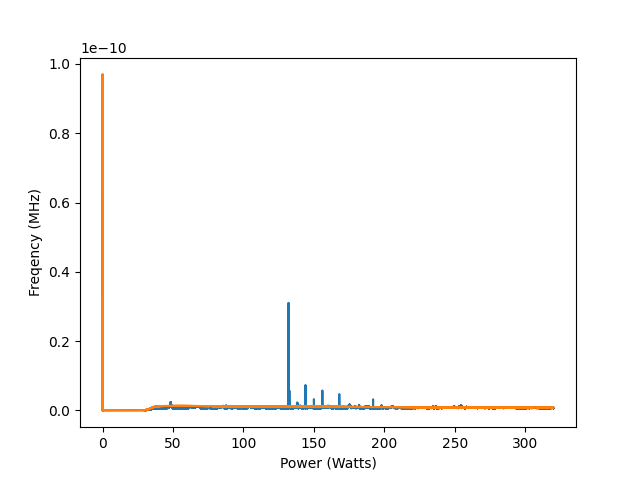

In [65]:
avgAntSpec  = np.load(dataDir+'avgAntSpec_W_296Avgs_3_23_23.npy', allow_pickle=True)
avgTermSpec = np.load(dataDir+'avgTermSpec_W_296Avgs_3_23_23.npy', allow_pickle=True)

freqs       = np.linspace(0, 320, 2**23)

plt.close('all')
plt.figure()
plt.plot(freqs, avgAntSpec[1:], label = 'Ant')
plt.plot(freqs, avgTermSpec[1:], label = 'Term')
plt.xlabel('Power (Watts)')
plt.ylabel('Freqency (MHz)')

In [ ]:
def rollingMadLim(spec,
    nSigma = 5,
    order = 1,
    fc_numBins = 100
):
    specFiltered = dr.filterSpec(spec, fc_numBins=fc_numBins, order=order)
    window = 1000

    rollingMadArr = dr.rolling(specFiltered, window, 1, mad_np, numProc=48)

    filter_fc           = 30 * window
    filteredMadArr  = dr.filterSpec(rollingMadArr, order = 2, fc_numBins = filter_fc, type = 'lowpass')
    diffFilterMadPadArr = dr.nanPad(filteredMadArr, window)
    rollMadLim      = diffFilterMadPadArr * nSigma * 1.48
    return rollingMadLim, nSigma, order, fc_numBins

antRollingMadLim, Sigma, order, fc_numBins     = rollingMadLim(avgAntSpec)
termRollingMadLim, nSigma, order, fc_numBins    = rollingMadLim(avgTermSpec)


np.save('/drBiggerBoy/moreTesting_3_23_23/antRollingMadLim_W_296Avgs_3_23_23', avgAntSpec)
np.save('/drBiggerBoy/moreTesting_3_23_23/termRollingMadLim_W_296Avgs_3_23_23', avgtermSpec)